1. Carga los datos usando la función "fetch_openml". Preprocesa los datos y realiza una visualización. Separa los datos en train (2/3) y test (1/3).
2. Entrena un regresor lineal para predecir la variable target (el precio) a partir de las 16 características de entrada. Calcula el Mean Absolute Error (MAE) sobre el conjunto de test. Debería ser alrededor de 25000 EUR.
3. Entrena y evalua los métodos kernel ridge regression con aproximación Nyström y aproxiación RFF. Reporta su MAE sobre el conjunto de test. Ojo: el regresor en este caso consiste en un Pipeline que contiene la aproximación seguida por una regresión Ridge (lineal); No contiene el método KernelRidge explícitamente. Usa el método GridSearchCV para encontrar valores adecuados de los parámetros.
4. Escribe un comentario sobre la complejidad computacional de ambos métodos, bajo la configuración de parámetros usada.

In [29]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge
from sklearn import pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import GridSearchCV
import time
from sklearn.kernel_ridge import KernelRidge

In [37]:
data = fetch_openml('house_16H')

C:\Users\migue\miniconda3\Lib\site-packages\sklearn\datasets\_openml.py:311: UserWarning: Multiple active versions of the dataset matching the name house_16h exist. Versions may be fundamentally different, returning version 1.
  warn(
C:\Users\migue\miniconda3\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [38]:
data.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [39]:
#descripción del dataset
data['DESCR']

'**Author**:   \n**Source**: Unknown - Date unknown  \n**Please cite**:   \n\nThis database was designed on the basis of data provided by US Census\nBureau [http://www.census.gov] (under Lookup Access\n[http://www.census.gov/cdrom/lookup]: Summary Tape File 1). The data\nwere collected as part of the 1990 US census. These are mostly counts\ncumulated at different survey levels. For the purpose of this data set\na level State-Place was used. Data from all states was obtained. Most\nof the counts were changed into appropriate proportions.  There are 4\ndifferent data sets obtained from this database: House(8H) House(8L)\nHouse(16H) House(16L) These are all concerned with predicting the\nmedian price of the house in the region based on demographic\ncomposition and a state of housing market in the region. A number in\nthe name signifies the number of attributes of the data set. A\nfollowing letter denotes a very rough approximation to the difficulty\nof the task. For Low task difficulty, m

In [40]:
X=data['data']

In [41]:
y=data['target']

In [42]:
X.head(3)

,P1,P5p1,P6p2,P11p4,P14p9,P15p1,P15p3,P16p2,P18p2,P27p4,H2p2,H8p2,H10p1,H13p1,H18pA,H40p4
0,15512.0,0.460869,0.049252,0.226470,0.149827,0.752837,0.010057,0.579729,0.003251,0.075912,0.625318,0.036613,0.991377,0.260116,0.052246,0.774059
1,1550.0,0.470968,0.002581,0.137419,0.096341,0.862581,0.000000,0.695142,0.005025,0.043551,0.064263,0.003350,0.994975,0.285266,0.060606,0.142857
2,4741.0,0.485341,0.000211,0.189412,0.135656,0.856992,0.000000,0.683584,0.004143,0.027965,0.065796,0.000000,0.997411,0.315433,0.065116,0.687500


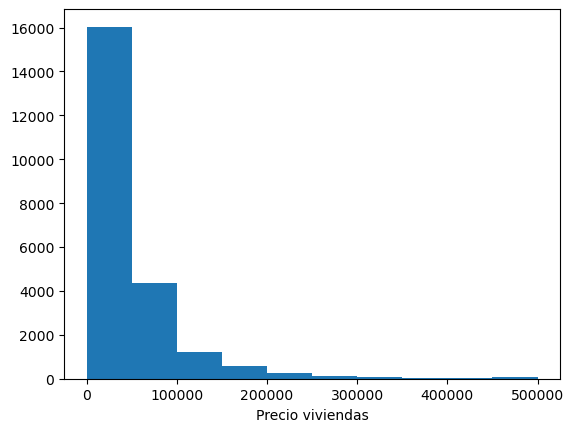

In [43]:
plt.hist(y)
plt.xlabel('Precio viviendas')
plt.show()

In [44]:
#escalamiento
meanX = np.mean(X, axis=0)
stdX = np.std(X, axis=0)
X=(X-meanX)/stdX

In [45]:
#separación train y test
test_size = 1/3

n = len(X)

# randomly permute the data
np.random.seed(0)
order = np.random.permutation(n)
indtest = order[:int(test_size * n)]
indtrain = order[int(test_size * n):]

In [46]:
X_train = X.loc[indtrain]
y_train = y[indtrain]
X_test = X.loc[indtest]
y_test = y[indtest]

print('X_train shape: '+str(X_train.shape))
print('X_test shape: '+str(X_test.shape))

X_train shape: (15190, 16)
X_test shape: (7594, 16)


In [47]:
#entrenamiento del regresor lineal

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
print('MAE sobre el conjunto de test: '+str(mean_absolute_error(y_test,y_pred)))

MAE sobre el conjunto de test: 25451.179414642334


In [48]:
#métodos KRR
#aproximacion Nystroem

#modelo
nys_krr = pipeline.Pipeline([
                    ('nystroem',Nystroem()),
                    ('ridge',Ridge())
                    ])

In [49]:
param_grid_nys= {
    'nystroem__n_components': [int(0.1*n)], 
    'nystroem__gamma': [0.001, 0.1, 10, 1000],  
    'ridge__alpha': [0.1, 1.0, 10]  }

grid_search_nystroem = GridSearchCV(estimator=nys_krr, param_grid=param_grid_nys, cv=5, scoring='neg_mean_absolute_error')

In [50]:
grid_search_nystroem.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('nystroem', Nystroem()),
                                       ('ridge', Ridge())]),
             param_grid={'nystroem__gamma': [0.001, 0.1, 10, 1000],
                         'nystroem__n_components': [2278],
                         'ridge__alpha': [0.1, 1.0, 10]},
             scoring='neg_mean_absolute_error')

In [51]:
print("Mejores parámetros:", grid_search_nystroem.best_params_)

Mejores parámetros: {'nystroem__gamma': 0.1, 'nystroem__n_components': 2278, 'ridge__alpha': 1.0}


In [52]:
y_pred_nys = grid_search_nystroem.predict(X_test)
print('MAE KRR + Nystroem: '+str(mean_absolute_error(y_test,y_pred_nys)))

MAE KRR + Nystroem: 18356.463904867516


In [53]:
#métodos KRR
#aproximacion RFF

#modelo
rff_krr = pipeline.Pipeline([
                    ('rff',RBFSampler()),
                    ('ridge',Ridge())
                    ])

In [54]:
param_grid_rff= {
    'rff__n_components': [int(0.1*n)], 
    'rff__gamma': [0.001, 0.1, 10, 1000],  
    'ridge__alpha': [0.1, 1.0, 10]  }

grid_search_rff = GridSearchCV(estimator=rff_krr, param_grid=param_grid_rff, cv=5, scoring='neg_mean_absolute_error')

In [55]:
grid_search_rff.fit(X,y)
print("Mejores parámetros:", grid_search_rff.best_params_)
y_pred_rff = grid_search_rff.predict(X_test)
print('MAE KRR + RFF: '+str(mean_absolute_error(y_test,y_pred_rff)))

Mejores parámetros: {'rff__gamma': 0.1, 'rff__n_components': 2278, 'ridge__alpha': 1.0}
MAE KRR + RFF: 18183.56759494503


In [56]:
#comentarios
#tiempos de cómputo

#rff optimo
n_components = 2278 # dimension of approximation
gamma = 0.1 # kernel parameter
alpha = 1

feature_map_fourier = RBFSampler(gamma=gamma, n_components=n_components, random_state=0)
ridge_reg = Ridge(alpha = alpha)
fourier_approx_krr = pipeline.Pipeline([("feature_map", feature_map_fourier),
                                        ("ridge", ridge_reg)])
start = time.time()
fourier_approx_krr.fit(X_train,y_train)
elapsed_timerff = time.time() - start

In [57]:
#nys optimo
n_components = 2278 # dimension of approximation
gamma = 0.1 # kernel parameter
alpha = 1

feature_map_nystroem = Nystroem(gamma=gamma, n_components=n_components, random_state=0)
ridge_reg = Ridge(alpha = alpha)
nystroem_approx_krr = pipeline.Pipeline([("feature_map", feature_map_nystroem),
                                        ("ridge", ridge_reg)])
start = time.time()
nystroem_approx_krr.fit(X_train,y_train)
elapsed_timenys = time.time() - start

In [58]:
start = time.time()
lin_reg.fit(X_train, y_train)
elapsed_timelin = time.time() - start

In [59]:
#kernel ridge sin aproximacion
kernel_ridge_model = KernelRidge(kernel='rbf')
start = time.time()
kernel_ridge_model.fit(X_train, y_train)
elapsed_timekr = time.time() - start

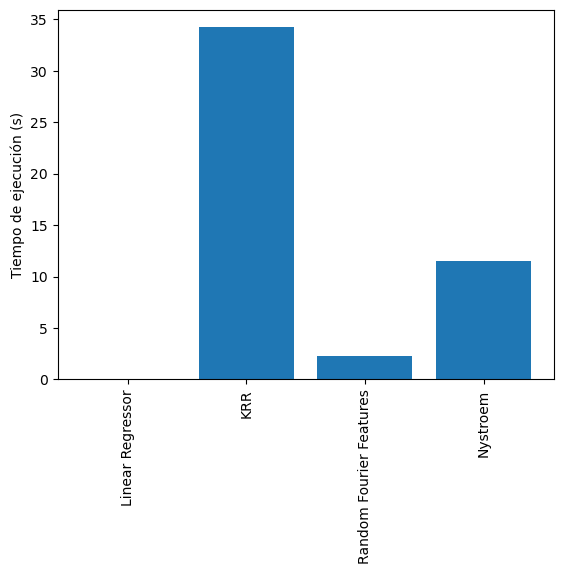

In [60]:
x=['Linear Regressor','KRR','Random Fourier Features','Nystroem']
y=[elapsed_timelin,elapsed_timekr,elapsed_timerff,elapsed_timenys]
plt.bar(x, y)

plt.xticks(rotation=90)
plt.ylabel('Tiempo de ejecución (s)')
plt.show()

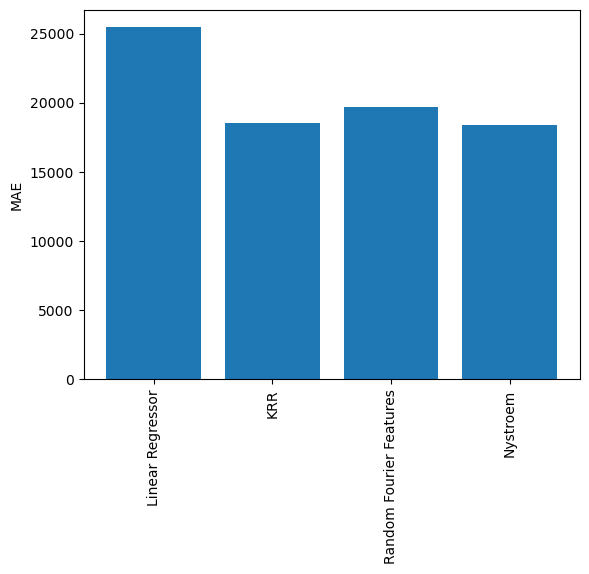

In [61]:
x=['Linear Regressor','KRR','Random Fourier Features','Nystroem']
y_pred_rff = fourier_approx_krr.predict(X_test)
y_pred_nys = nystroem_approx_krr.predict(X_test)
y_pred_kr = kernel_ridge_model.predict(X_test)
y=[mean_absolute_error(y_test,y_pred),mean_absolute_error(y_test,y_pred_kr),mean_absolute_error(y_test,y_pred_rff),mean_absolute_error(y_test,y_pred_nys)]
plt.bar(x, y)

plt.xticks(rotation=90)
plt.ylabel('MAE')
plt.show()

Se han comparado los tiempos de entrenamiento de los dos métodos de aproximación del kernel usados, para los parámetros óptimos encontrados en cada caso, con el método Kernel Ridge sin aproximación y el método lineal. Se observan tiempos de ejecución mayor en general de los métodos kernel respecto al regresor lineal, y, entre los dos modelos de aproximación, un tiempo de cómputo mayor para la aproximación Nystroem que para la aproximación RFF bajo el mismo número de componentes. Por otro lado, como cabría esperar, se observa un tiempo de ejecución del método KRR, que no tiene aproximación del kernel, mayor que los de los métodos con aproximaciones. 

Por otro lado, se consigue una mejora en el MAE de la predicción realizada sobre el conjunto de test con los modelos kernel en comparación con el regresor lineal usado al principio. Además, las precisiones de los métodos kernel son parecidas entre ellos, por lo que las aproximaciones han funcionado bien. Atendiendo a esto último y a los tiempos de computación, la mejor opción para entrenar un modelo es en principio RFF + KRR.